In [2]:
import numpy as np
import cv2
import wget
from zipfile import ZipFile
import os

#######################################################

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten
#from tensorflow.keras import utils as np_utils # transform les label en categories
import matplotlib.pyplot as plt
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.activations import *
from tensorflow.keras.datasets import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *


In [3]:
DATASET_URL = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18648/1026645/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1590765878&Signature=lWaCgzE5%2FZYXHtfm16YFKzQ9TqxWAOzh7insAs6qS5b4naboqxje%2FmUWdjALcswZLsB4VzzKNg8ZSUqmx87UX7jRqnlEQCAevlmBDWb4UIvvfErIJnGs%2BNTCtu1MAligXP1CEE%2BVS0rPWuJPe9eNkrtLz5EKd3Bd6Qbk%2Bgp4xO9sFzMVd%2BD11OfypzT9DvPLhYv6zfQU4pNI4DRHCqU1nlCL%2BW5fzB3PUbMDKpVj7axreGcMAJmqYbZHsUXc49SwR7ZMhx3yk6Inkzp6W83b2J2OmCJiA9Az%2Bjd9VEVTaST1r3Hm6m6peAZc1Jn%2BI3%2FNE6DkH%2BVK7zGxs9mlkrq5lg%3D%3D&response-content-disposition=attachment%3B+filename%3Dplant-pathology-2020-fgvc7.zip"
DATASET_TARGET = "./data/"
TRAIN_CSV_PATH = "./data/train.csv"
IMG_PATH = "./data/images/"
IMG_EXT = ".jpg"
TRAIN_PROPORTION = 0.8

In [4]:
def download_dataset():
    print("Plant Health dataset downloading.")

    try:
        os.mkdir(DATASET_TARGET)
        print("Creation of {}.".format(DATASET_TARGET))
    except FileExistsError as e:
        print("Directory {} already exist.".format(DATASET_TARGET))
        if os.path.exists(DATASET_TARGET) and os.path.exists(TRAIN_CSV_PATH) and os.path.exists(IMG_PATH):
            print("Dataset already install.")
            return

    print("Downloading dataset from kaggle.")
    filename = wget.download(DATASET_URL, DATASET_TARGET)

    print("Extract dataset of {}.".format(filename))
    with ZipFile(filename) as zf:
        zf.extractall(DATASET_TARGET)

    os.remove(filename)



In [5]:
# retourne le nom des échantillojn avec leur pathologie
def get_all_dataset(train_path):
    try:

        print("Load plant image names and pathologies.")
        file = open(train_path, "r")
        lines = file.readlines()
        lines = lines[1:]
        img_label = []
        expectations = []

        i = 0
        while i < len(lines):
            lines[i] = lines[i].replace("\n", "")
            row = lines[i].split(",")
            pathology = [row[1], row[2], row[3], row[4]]
            img_label.append(row[0])
            expectations.append(pathology.index("1"))
            i += 1

        return img_label, expectations

    except Exception as e:

        print(e)



In [6]:
# retourne les images à partir de leurs noms
def get_img(img_label, img_path, img_size):
    try:

        print("Load plant images.")
        imgs = []

        for label in img_label:
            img_np = cv2.imread(img_path + label + IMG_EXT)
            img_np = cv2.resize(img_np, img_size)
            imgs.append(img_np)

        return imgs

    except Exception as e:

        print(e)


In [7]:
# forme le dataset
def get_final_dataset(imgs, expectations):
    try:

        print("Creation of the final dataset.")
        x_train = []
        y_train = []
        x_test = []
        y_test = []

        nb_train_data = int(len(imgs) * TRAIN_PROPORTION)

        for i in range(0, len(imgs)):

            if i < nb_train_data:
                x_train.append(imgs[i])
                y_train.append(expectations[i])

            else:
                x_test.append(imgs[i])
                y_test.append(expectations[i])

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    except Exception as e:

        print(e)


In [8]:
# fonction a appelé pour charger le dataset
def load_dataset(img_size):
    download_dataset()
    img_lab, expectations = get_all_dataset(TRAIN_CSV_PATH)
    imgs = get_img(img_lab, IMG_PATH, img_size)
    return get_final_dataset(imgs, expectations)

In [9]:
x_train, y_train,x_test, y_test=load_dataset((64,64))

Plant Health dataset downloading.
Directory ./data/ already exist.
Dataset already install.
Load plant image names and pathologies.
Load plant images.
Creation of the final dataset.


In [10]:
print(x_train.shape)
print(y_train.shape)

(1456, 64, 64, 3)
(1456,)


In [11]:
mean = np.mean(x_train, axis= (0,1,2,3))
std = np.std(x_train ,axis= (0,1,2,3))
x_train = (x_train - mean)/ (std+ 1e-7)
x_test = (x_test - mean)/ (std+ 1e-7)

In [12]:
input_shape= (64,64,3)

In [13]:
def creatModel_5():
    classifier= Sequential()
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu',input_shape = input_shape))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    classifier.add(Conv2D(128,(3,3),strides=(1,1),padding= 'same', activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    
    
    
    classifier.add(Flatten())   
       
    
    #classifier.add(Dense(units= 256, activation = 'relu'))
    #classifier.add(Dropout(0.5))
    classifier.add(Dense(units= 4, activation = 'softmax'))
   
    classifier.compile(optimizer= Adam(), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

classifier_5= creatModel_5()

In [15]:
history_5 = classifier_5.fit(x_train, y_train, epochs=1500, batch_size=128, validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 1.2060 - accuracy: 0.3942 - val_loss: 1.3128 - val_accuracy: 0.4247
Epoch 2/1500
1456/1456 [==============================] - 1s 877us/sample - loss: 1.1736 - accuracy: 0.4478 - val_loss: 1.2913 - val_accuracy: 0.4822
Epoch 3/1500
1456/1456 [==============================] - 1s 856us/sample - loss: 1.1321 - accuracy: 0.4931 - val_loss: 1.2769 - val_accuracy: 0.4575
Epoch 4/1500
1456/1456 [==============================] - 1s 852us/sample - loss: 1.1107 - accuracy: 0.4938 - val_loss: 1.2517 - val_accuracy: 0.5014
Epoch 5/1500
1456/1456 [==============================] - 1s 847us/sample - loss: 1.0889 - accuracy: 0.5048 - val_loss: 1.2804 - val_accuracy: 0.4904
Epoch 6/1500
1456/1456 [==============================] - 1s 848us/sample - loss: 1.0571 - accuracy: 0.5364 - val_loss: 1.2774 - val_accuracy: 0.4712
Epoch 7/1500
1456/1456 [=============================

1456/1456 [==============================] - 1s 835us/sample - loss: 0.0966 - accuracy: 0.9677 - val_loss: 1.2009 - val_accuracy: 0.4795
Epoch 56/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0806 - accuracy: 0.9746 - val_loss: 1.2167 - val_accuracy: 0.4822
Epoch 57/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0885 - accuracy: 0.9684 - val_loss: 1.1909 - val_accuracy: 0.5041
Epoch 58/1500
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0801 - accuracy: 0.9705 - val_loss: 1.2216 - val_accuracy: 0.4603
Epoch 59/1500
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0916 - accuracy: 0.9677 - val_loss: 1.2801 - val_accuracy: 0.4603
Epoch 60/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0893 - accuracy: 0.9643 - val_loss: 1.1683 - val_accuracy: 0.4849
Epoch 61/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0949 - accuracy: 0.9670

1456/1456 [==============================] - 1s 838us/sample - loss: 0.0459 - accuracy: 0.9835 - val_loss: 1.2541 - val_accuracy: 0.5014
Epoch 110/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0585 - accuracy: 0.9787 - val_loss: 1.2829 - val_accuracy: 0.5123
Epoch 111/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0786 - accuracy: 0.9732 - val_loss: 1.2106 - val_accuracy: 0.5342
Epoch 112/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0455 - accuracy: 0.9821 - val_loss: 1.2734 - val_accuracy: 0.5041
Epoch 113/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0572 - accuracy: 0.9794 - val_loss: 1.2538 - val_accuracy: 0.5123
Epoch 114/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0567 - accuracy: 0.9835 - val_loss: 1.1569 - val_accuracy: 0.5562
Epoch 115/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0578 - accuracy: 

Epoch 163/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0245 - accuracy: 0.9911 - val_loss: 1.1372 - val_accuracy: 0.6082
Epoch 164/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0187 - accuracy: 0.9945 - val_loss: 1.1832 - val_accuracy: 0.5973
Epoch 165/1500
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0263 - accuracy: 0.9897 - val_loss: 1.1232 - val_accuracy: 0.6027
Epoch 166/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0143 - accuracy: 0.9959 - val_loss: 1.1129 - val_accuracy: 0.6137
Epoch 167/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0135 - accuracy: 0.9966 - val_loss: 1.1240 - val_accuracy: 0.6027
Epoch 168/1500
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0314 - accuracy: 0.9918 - val_loss: 1.1194 - val_accuracy: 0.6219
Epoch 169/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.01

Epoch 217/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0299 - accuracy: 0.9924 - val_loss: 1.0920 - val_accuracy: 0.6411
Epoch 218/1500
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0201 - accuracy: 0.9938 - val_loss: 1.1332 - val_accuracy: 0.6164
Epoch 219/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0337 - accuracy: 0.9883 - val_loss: 1.1152 - val_accuracy: 0.6137
Epoch 220/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0299 - accuracy: 0.9876 - val_loss: 1.1460 - val_accuracy: 0.6137
Epoch 221/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0410 - accuracy: 0.9876 - val_loss: 1.1310 - val_accuracy: 0.6329
Epoch 222/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0242 - accuracy: 0.9890 - val_loss: 1.1411 - val_accuracy: 0.6301
Epoch 223/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.04

Epoch 271/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0148 - accuracy: 0.9952 - val_loss: 1.1650 - val_accuracy: 0.6301
Epoch 272/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0164 - accuracy: 0.9945 - val_loss: 1.1193 - val_accuracy: 0.6247
Epoch 273/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0262 - accuracy: 0.9897 - val_loss: 1.1908 - val_accuracy: 0.6274
Epoch 274/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0148 - accuracy: 0.9938 - val_loss: 1.1147 - val_accuracy: 0.6493
Epoch 275/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0170 - accuracy: 0.9931 - val_loss: 1.1759 - val_accuracy: 0.6466
Epoch 276/1500
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0181 - accuracy: 0.9945 - val_loss: 1.2236 - val_accuracy: 0.6274
Epoch 277/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.02

Epoch 325/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0133 - accuracy: 0.9966 - val_loss: 1.0777 - val_accuracy: 0.6986
Epoch 326/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0144 - accuracy: 0.9966 - val_loss: 1.1692 - val_accuracy: 0.6575
Epoch 327/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0105 - accuracy: 0.9973 - val_loss: 1.1074 - val_accuracy: 0.6877
Epoch 328/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0051 - accuracy: 0.9979 - val_loss: 1.0927 - val_accuracy: 0.6877
Epoch 329/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0188 - accuracy: 0.9945 - val_loss: 1.0528 - val_accuracy: 0.6904
Epoch 330/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0080 - accuracy: 0.9986 - val_loss: 1.0522 - val_accuracy: 0.6849
Epoch 331/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.01

Epoch 379/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0260 - accuracy: 0.9924 - val_loss: 1.1472 - val_accuracy: 0.6712
Epoch 380/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0407 - accuracy: 0.9911 - val_loss: 1.1023 - val_accuracy: 0.6247
Epoch 381/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0132 - accuracy: 0.9945 - val_loss: 1.0836 - val_accuracy: 0.6247
Epoch 382/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0115 - accuracy: 0.9959 - val_loss: 1.0160 - val_accuracy: 0.6822
Epoch 383/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0166 - accuracy: 0.9938 - val_loss: 1.0770 - val_accuracy: 0.6932
Epoch 384/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0291 - accuracy: 0.9897 - val_loss: 1.0661 - val_accuracy: 0.6822
Epoch 385/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.02

Epoch 433/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0337 - accuracy: 0.9890 - val_loss: 1.1843 - val_accuracy: 0.6712
Epoch 434/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0482 - accuracy: 0.9856 - val_loss: 1.1245 - val_accuracy: 0.6603
Epoch 435/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0447 - accuracy: 0.9870 - val_loss: 1.1049 - val_accuracy: 0.7068
Epoch 436/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0208 - accuracy: 0.9904 - val_loss: 1.3174 - val_accuracy: 0.6548
Epoch 437/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0414 - accuracy: 0.9883 - val_loss: 1.0897 - val_accuracy: 0.6822
Epoch 438/1500
1456/1456 [==============================] - 1s 845us/sample - loss: 0.0219 - accuracy: 0.9911 - val_loss: 1.1610 - val_accuracy: 0.6822
Epoch 439/1500
1456/1456 [==============================] - 1s 844us/sample - loss: 0.01

1456/1456 [==============================] - 1s 836us/sample - loss: 0.0095 - accuracy: 0.9966 - val_loss: 1.1108 - val_accuracy: 0.6959
Epoch 487/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0277 - accuracy: 0.9945 - val_loss: 1.0705 - val_accuracy: 0.6630
Epoch 488/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0176 - accuracy: 0.9959 - val_loss: 1.0583 - val_accuracy: 0.6712
Epoch 489/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0290 - accuracy: 0.9931 - val_loss: 1.0407 - val_accuracy: 0.7205
Epoch 490/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0339 - accuracy: 0.9918 - val_loss: 1.0966 - val_accuracy: 0.7315
Epoch 491/1500
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0182 - accuracy: 0.9938 - val_loss: 1.1357 - val_accuracy: 0.6822
Epoch 492/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0152 - accuracy: 

Epoch 540/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0526 - accuracy: 0.9863 - val_loss: 1.1426 - val_accuracy: 0.7014
Epoch 541/1500
1456/1456 [==============================] - 1s 830us/sample - loss: 0.0204 - accuracy: 0.9931 - val_loss: 1.1475 - val_accuracy: 0.7041
Epoch 542/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0165 - accuracy: 0.9938 - val_loss: 1.0616 - val_accuracy: 0.7233
Epoch 543/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0222 - accuracy: 0.9931 - val_loss: 1.1760 - val_accuracy: 0.6904
Epoch 544/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0141 - accuracy: 0.9938 - val_loss: 1.1658 - val_accuracy: 0.6959
Epoch 545/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0076 - accuracy: 0.9966 - val_loss: 1.2216 - val_accuracy: 0.6986
Epoch 546/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.01

Epoch 594/1500
1456/1456 [==============================] - 1s 847us/sample - loss: 0.0082 - accuracy: 0.9979 - val_loss: 1.1205 - val_accuracy: 0.7233
Epoch 595/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0152 - accuracy: 0.9973 - val_loss: 1.0657 - val_accuracy: 0.7315
Epoch 596/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0102 - accuracy: 0.9959 - val_loss: 1.0542 - val_accuracy: 0.7260
Epoch 597/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0075 - accuracy: 0.9973 - val_loss: 1.0027 - val_accuracy: 0.7342
Epoch 598/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0090 - accuracy: 0.9966 - val_loss: 1.0384 - val_accuracy: 0.7233
Epoch 599/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0105 - accuracy: 0.9973 - val_loss: 1.0562 - val_accuracy: 0.7178
Epoch 600/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.00

Epoch 648/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0136 - accuracy: 0.9952 - val_loss: 1.2873 - val_accuracy: 0.7233
Epoch 649/1500
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0159 - accuracy: 0.9938 - val_loss: 1.2420 - val_accuracy: 0.7205
Epoch 650/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0144 - accuracy: 0.9959 - val_loss: 1.2426 - val_accuracy: 0.7288
Epoch 651/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0140 - accuracy: 0.9945 - val_loss: 1.1902 - val_accuracy: 0.7288
Epoch 652/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0108 - accuracy: 0.9973 - val_loss: 1.1696 - val_accuracy: 0.7123
Epoch 653/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0077 - accuracy: 0.9973 - val_loss: 1.1620 - val_accuracy: 0.7096
Epoch 654/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.01

Epoch 702/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0128 - accuracy: 0.9959 - val_loss: 1.1622 - val_accuracy: 0.7479
Epoch 703/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0173 - accuracy: 0.9966 - val_loss: 1.1468 - val_accuracy: 0.7644
Epoch 704/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0080 - accuracy: 0.9966 - val_loss: 1.1534 - val_accuracy: 0.7452
Epoch 705/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0087 - accuracy: 0.9979 - val_loss: 1.1316 - val_accuracy: 0.7534
Epoch 706/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0014 - accuracy: 0.9993 - val_loss: 1.1202 - val_accuracy: 0.7452
Epoch 707/1500
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0066 - accuracy: 0.9979 - val_loss: 1.0843 - val_accuracy: 0.7534
Epoch 708/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.01

Epoch 756/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0317 - accuracy: 0.9911 - val_loss: 1.2150 - val_accuracy: 0.7151
Epoch 757/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0189 - accuracy: 0.9938 - val_loss: 1.2428 - val_accuracy: 0.7068
Epoch 758/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0279 - accuracy: 0.9931 - val_loss: 1.3396 - val_accuracy: 0.7151
Epoch 759/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0346 - accuracy: 0.9924 - val_loss: 1.3942 - val_accuracy: 0.7151
Epoch 760/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0157 - accuracy: 0.9945 - val_loss: 1.4032 - val_accuracy: 0.7178
Epoch 761/1500
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0234 - accuracy: 0.9945 - val_loss: 1.3314 - val_accuracy: 0.7068
Epoch 762/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.01

Epoch 810/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0069 - accuracy: 0.9973 - val_loss: 1.3124 - val_accuracy: 0.7781
Epoch 811/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0140 - accuracy: 0.9966 - val_loss: 1.3755 - val_accuracy: 0.7589
Epoch 812/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0132 - accuracy: 0.9979 - val_loss: 1.4415 - val_accuracy: 0.7479
Epoch 813/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0170 - accuracy: 0.9938 - val_loss: 1.4549 - val_accuracy: 0.7479
Epoch 814/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0219 - accuracy: 0.9952 - val_loss: 1.3865 - val_accuracy: 0.7342
Epoch 815/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0327 - accuracy: 0.9931 - val_loss: 1.3650 - val_accuracy: 0.7534
Epoch 816/1500
1456/1456 [==============================] - 1s 845us/sample - loss: 0.00

Epoch 864/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0163 - accuracy: 0.9973 - val_loss: 1.3621 - val_accuracy: 0.7397
Epoch 865/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0039 - accuracy: 0.9986 - val_loss: 1.3627 - val_accuracy: 0.7315
Epoch 866/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0070 - accuracy: 0.9986 - val_loss: 1.3152 - val_accuracy: 0.7370
Epoch 867/1500
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0049 - accuracy: 0.9986 - val_loss: 1.2988 - val_accuracy: 0.7425
Epoch 868/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0067 - accuracy: 0.9986 - val_loss: 1.2762 - val_accuracy: 0.7616
Epoch 869/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0076 - accuracy: 0.9979 - val_loss: 1.2750 - val_accuracy: 0.7699
Epoch 870/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.00

Epoch 918/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0132 - accuracy: 0.9973 - val_loss: 1.5032 - val_accuracy: 0.7315
Epoch 919/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0118 - accuracy: 0.9966 - val_loss: 1.4352 - val_accuracy: 0.7726
Epoch 920/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0063 - accuracy: 0.9973 - val_loss: 1.4054 - val_accuracy: 0.7753
Epoch 921/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0231 - accuracy: 0.9979 - val_loss: 1.3912 - val_accuracy: 0.7753
Epoch 922/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0115 - accuracy: 0.9973 - val_loss: 1.3890 - val_accuracy: 0.7699
Epoch 923/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0066 - accuracy: 0.9979 - val_loss: 1.3514 - val_accuracy: 0.7644
Epoch 924/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.00

Epoch 972/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0076 - accuracy: 0.9966 - val_loss: 1.3730 - val_accuracy: 0.7534
Epoch 973/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0084 - accuracy: 0.9966 - val_loss: 1.4114 - val_accuracy: 0.7589
Epoch 974/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0147 - accuracy: 0.9979 - val_loss: 1.3856 - val_accuracy: 0.7699
Epoch 975/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0195 - accuracy: 0.9952 - val_loss: 1.2794 - val_accuracy: 0.7671
Epoch 976/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0180 - accuracy: 0.9952 - val_loss: 1.2893 - val_accuracy: 0.7699
Epoch 977/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0123 - accuracy: 0.9979 - val_loss: 1.2759 - val_accuracy: 0.8027
Epoch 978/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.00

Epoch 1026/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0076 - accuracy: 0.9973 - val_loss: 1.4652 - val_accuracy: 0.7479
Epoch 1027/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0032 - accuracy: 0.9993 - val_loss: 1.3921 - val_accuracy: 0.7397
Epoch 1028/1500
1456/1456 [==============================] - 1s 844us/sample - loss: 8.3246e-04 - accuracy: 1.0000 - val_loss: 1.4211 - val_accuracy: 0.7425
Epoch 1029/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0021 - accuracy: 0.9993 - val_loss: 1.4934 - val_accuracy: 0.7562
Epoch 1030/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0068 - accuracy: 0.9979 - val_loss: 1.4954 - val_accuracy: 0.7370
Epoch 1031/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0048 - accuracy: 0.9986 - val_loss: 1.5524 - val_accuracy: 0.7452
Epoch 1032/1500
1456/1456 [==============================] - 1s 841us/sample -

1456/1456 [==============================] - 1s 836us/sample - loss: 0.0117 - accuracy: 0.9966 - val_loss: 1.4585 - val_accuracy: 0.7589
Epoch 1080/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0067 - accuracy: 0.9979 - val_loss: 1.4669 - val_accuracy: 0.7726
Epoch 1081/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0073 - accuracy: 0.9979 - val_loss: 1.4849 - val_accuracy: 0.7671
Epoch 1082/1500
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0090 - accuracy: 0.9966 - val_loss: 1.5152 - val_accuracy: 0.7808
Epoch 1083/1500
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0170 - accuracy: 0.9966 - val_loss: 1.5139 - val_accuracy: 0.7781
Epoch 1084/1500
1456/1456 [==============================] - 1s 834us/sample - loss: 8.2506e-04 - accuracy: 0.9993 - val_loss: 1.5289 - val_accuracy: 0.7726
Epoch 1085/1500
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0098 - 

1456/1456 [==============================] - 1s 881us/sample - loss: 0.0270 - accuracy: 0.9945 - val_loss: 1.6370 - val_accuracy: 0.7781
Epoch 1133/1500
1456/1456 [==============================] - 1s 868us/sample - loss: 0.0112 - accuracy: 0.9986 - val_loss: 1.6370 - val_accuracy: 0.7753
Epoch 1134/1500
1456/1456 [==============================] - 1s 855us/sample - loss: 0.0600 - accuracy: 0.9911 - val_loss: 1.6720 - val_accuracy: 0.7808
Epoch 1135/1500
1456/1456 [==============================] - 1s 862us/sample - loss: 0.0238 - accuracy: 0.9959 - val_loss: 1.6355 - val_accuracy: 0.7726
Epoch 1136/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0012 - accuracy: 0.9993 - val_loss: 1.6072 - val_accuracy: 0.7616
Epoch 1137/1500
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0271 - accuracy: 0.9945 - val_loss: 1.5812 - val_accuracy: 0.7753
Epoch 1138/1500
1456/1456 [==============================] - 1s 869us/sample - loss: 0.0228 - accu

1456/1456 [==============================] - 1s 847us/sample - loss: 0.0211 - accuracy: 0.9966 - val_loss: 1.8168 - val_accuracy: 0.7671
Epoch 1186/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0114 - accuracy: 0.9966 - val_loss: 1.8273 - val_accuracy: 0.7562
Epoch 1187/1500
1456/1456 [==============================] - 1s 848us/sample - loss: 0.0215 - accuracy: 0.9986 - val_loss: 1.7976 - val_accuracy: 0.7479
Epoch 1188/1500
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0191 - accuracy: 0.9952 - val_loss: 1.7262 - val_accuracy: 0.7589
Epoch 1189/1500
1456/1456 [==============================] - 1s 845us/sample - loss: 0.0059 - accuracy: 0.9986 - val_loss: 1.7637 - val_accuracy: 0.7644
Epoch 1190/1500
1456/1456 [==============================] - 1s 851us/sample - loss: 0.0110 - accuracy: 0.9979 - val_loss: 1.7507 - val_accuracy: 0.7753
Epoch 1191/1500
1456/1456 [==============================] - 1s 848us/sample - loss: 0.0027 - accu

1456/1456 [==============================] - 1s 833us/sample - loss: 0.0074 - accuracy: 0.9979 - val_loss: 1.7789 - val_accuracy: 0.7726
Epoch 1239/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0046 - accuracy: 0.9986 - val_loss: 1.6870 - val_accuracy: 0.7890
Epoch 1240/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0074 - accuracy: 0.9979 - val_loss: 1.6570 - val_accuracy: 0.8000
Epoch 1241/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0078 - accuracy: 0.9986 - val_loss: 1.6702 - val_accuracy: 0.7918
Epoch 1242/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0162 - accuracy: 0.9973 - val_loss: 1.6453 - val_accuracy: 0.7836
Epoch 1243/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0239 - accuracy: 0.9945 - val_loss: 1.5873 - val_accuracy: 0.7726
Epoch 1244/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0222 - accu

1456/1456 [==============================] - 1s 835us/sample - loss: 0.0509 - accuracy: 0.9911 - val_loss: 1.8815 - val_accuracy: 0.7918
Epoch 1292/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0129 - accuracy: 0.9966 - val_loss: 1.8601 - val_accuracy: 0.7836
Epoch 1293/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0523 - accuracy: 0.9952 - val_loss: 2.2703 - val_accuracy: 0.7644
Epoch 1294/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0328 - accuracy: 0.9938 - val_loss: 2.1807 - val_accuracy: 0.8000
Epoch 1295/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0451 - accuracy: 0.9945 - val_loss: 2.1784 - val_accuracy: 0.7753
Epoch 1296/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0168 - accuracy: 0.9966 - val_loss: 2.0740 - val_accuracy: 0.7671
Epoch 1297/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0421 - accu

1456/1456 [==============================] - 1s 843us/sample - loss: 0.0036 - accuracy: 0.9986 - val_loss: 1.8954 - val_accuracy: 0.7753
Epoch 1345/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0034 - accuracy: 0.9993 - val_loss: 1.8925 - val_accuracy: 0.7863
Epoch 1346/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0122 - accuracy: 0.9973 - val_loss: 1.8508 - val_accuracy: 0.7781
Epoch 1347/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0115 - accuracy: 0.9979 - val_loss: 1.8521 - val_accuracy: 0.7726
Epoch 1348/1500
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0082 - accuracy: 0.9993 - val_loss: 1.8498 - val_accuracy: 0.7616
Epoch 1349/1500
1456/1456 [==============================] - 1s 840us/sample - loss: 1.7994e-04 - accuracy: 1.0000 - val_loss: 1.8494 - val_accuracy: 0.7699
Epoch 1350/1500
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0041 - 

1456/1456 [==============================] - 1s 843us/sample - loss: 0.0090 - accuracy: 0.9973 - val_loss: 2.2219 - val_accuracy: 0.7945
Epoch 1398/1500
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0237 - accuracy: 0.9966 - val_loss: 2.2964 - val_accuracy: 0.7945
Epoch 1399/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0239 - accuracy: 0.9973 - val_loss: 2.3502 - val_accuracy: 0.7890
Epoch 1400/1500
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0220 - accuracy: 0.9966 - val_loss: 2.3121 - val_accuracy: 0.7781
Epoch 1401/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0271 - accuracy: 0.9959 - val_loss: 2.4093 - val_accuracy: 0.7781
Epoch 1402/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0061 - accuracy: 0.9973 - val_loss: 2.3877 - val_accuracy: 0.7781
Epoch 1403/1500
1456/1456 [==============================] - 1s 846us/sample - loss: 0.0310 - accu

1456/1456 [==============================] - 1s 834us/sample - loss: 0.0140 - accuracy: 0.9979 - val_loss: 2.3495 - val_accuracy: 0.7918
Epoch 1451/1500
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0173 - accuracy: 0.9945 - val_loss: 2.2327 - val_accuracy: 0.7781
Epoch 1452/1500
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0223 - accuracy: 0.9973 - val_loss: 2.3535 - val_accuracy: 0.7753
Epoch 1453/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0158 - accuracy: 0.9973 - val_loss: 2.3679 - val_accuracy: 0.7589
Epoch 1454/1500
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0294 - accuracy: 0.9945 - val_loss: 2.3813 - val_accuracy: 0.7890
Epoch 1455/1500
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0287 - accuracy: 0.9959 - val_loss: 2.2827 - val_accuracy: 0.7808
Epoch 1456/1500
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0069 - accu

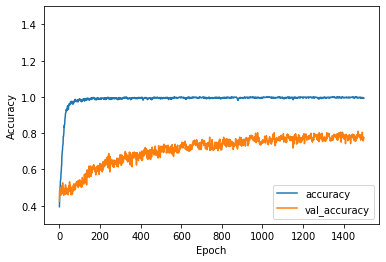

In [16]:
plt.plot(history_5.history['accuracy'], label='accuracy')
plt.plot(history_5.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')

In [17]:
history_5 = classifier_5.fit(x_train, y_train, epochs=1000, batch_size=128, validation_data=(x_test, y_test))

Train on 1456 samples, validate on 365 samples
Epoch 1/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0313 - accuracy: 0.9938 - val_loss: 2.2490 - val_accuracy: 0.7699
Epoch 2/1000
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0280 - accuracy: 0.9966 - val_loss: 2.3028 - val_accuracy: 0.7781
Epoch 3/1000
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0358 - accuracy: 0.9959 - val_loss: 2.3306 - val_accuracy: 0.7808
Epoch 4/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0286 - accuracy: 0.9959 - val_loss: 2.3870 - val_accuracy: 0.7699
Epoch 5/1000
1456/1456 [==============================] - 1s 858us/sample - loss: 0.0404 - accuracy: 0.9945 - val_loss: 2.3865 - val_accuracy: 0.7589
Epoch 6/1000
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0191 - accuracy: 0.9945 - val_loss: 2.0630 - val_accuracy: 0.7753
Epoch 7/1000
1456/1456 [=============================

Epoch 55/1000
1456/1456 [==============================] - 1s 853us/sample - loss: 0.0123 - accuracy: 0.9952 - val_loss: 2.6831 - val_accuracy: 0.7671
Epoch 56/1000
1456/1456 [==============================] - 1s 859us/sample - loss: 0.0077 - accuracy: 0.9979 - val_loss: 2.6751 - val_accuracy: 0.7644
Epoch 57/1000
1456/1456 [==============================] - 1s 855us/sample - loss: 0.0017 - accuracy: 0.9993 - val_loss: 2.6710 - val_accuracy: 0.7644
Epoch 58/1000
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0108 - accuracy: 0.9966 - val_loss: 2.4489 - val_accuracy: 0.7753
Epoch 59/1000
1456/1456 [==============================] - 1s 875us/sample - loss: 0.0091 - accuracy: 0.9973 - val_loss: 2.3571 - val_accuracy: 0.7836
Epoch 60/1000
1456/1456 [==============================] - 1s 858us/sample - loss: 0.0051 - accuracy: 0.9993 - val_loss: 2.3731 - val_accuracy: 0.7726
Epoch 61/1000
1456/1456 [==============================] - 1s 887us/sample - loss: 0.0275 - ac

1456/1456 [==============================] - 1s 827us/sample - loss: 0.0138 - accuracy: 0.9959 - val_loss: 2.1843 - val_accuracy: 0.7836
Epoch 110/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0075 - accuracy: 0.9979 - val_loss: 2.1737 - val_accuracy: 0.7863
Epoch 111/1000
1456/1456 [==============================] - 1s 847us/sample - loss: 0.0350 - accuracy: 0.9952 - val_loss: 2.2182 - val_accuracy: 0.7836
Epoch 112/1000
1456/1456 [==============================] - 1s 852us/sample - loss: 0.0302 - accuracy: 0.9966 - val_loss: 2.4640 - val_accuracy: 0.7644
Epoch 113/1000
1456/1456 [==============================] - 1s 860us/sample - loss: 0.0032 - accuracy: 0.9986 - val_loss: 2.5030 - val_accuracy: 0.7616
Epoch 114/1000
1456/1456 [==============================] - 1s 869us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.4798 - val_accuracy: 0.7699
Epoch 115/1000
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0025 - accuracy: 

Epoch 163/1000
1456/1456 [==============================] - 1s 828us/sample - loss: 0.0141 - accuracy: 0.9973 - val_loss: 2.7224 - val_accuracy: 0.8055
Epoch 164/1000
1456/1456 [==============================] - 1s 827us/sample - loss: 0.0054 - accuracy: 0.9993 - val_loss: 2.8179 - val_accuracy: 0.8027
Epoch 165/1000
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0309 - accuracy: 0.9959 - val_loss: 2.7448 - val_accuracy: 0.8082
Epoch 166/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0171 - accuracy: 0.9986 - val_loss: 2.7448 - val_accuracy: 0.8055
Epoch 167/1000
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0172 - accuracy: 0.9979 - val_loss: 2.8339 - val_accuracy: 0.7918
Epoch 168/1000
1456/1456 [==============================] - 1s 847us/sample - loss: 0.0390 - accuracy: 0.9973 - val_loss: 2.8155 - val_accuracy: 0.8000
Epoch 169/1000
1456/1456 [==============================] - 1s 846us/sample - loss: 0.01

Epoch 217/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0113 - accuracy: 0.9979 - val_loss: 2.8617 - val_accuracy: 0.7808
Epoch 218/1000
1456/1456 [==============================] - 1s 827us/sample - loss: 0.0127 - accuracy: 0.9966 - val_loss: 2.8503 - val_accuracy: 0.7836
Epoch 219/1000
1456/1456 [==============================] - 1s 825us/sample - loss: 0.0181 - accuracy: 0.9966 - val_loss: 3.0194 - val_accuracy: 0.7726
Epoch 220/1000
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0561 - accuracy: 0.9959 - val_loss: 2.9947 - val_accuracy: 0.7863
Epoch 221/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0065 - accuracy: 0.9986 - val_loss: 2.5967 - val_accuracy: 0.7918
Epoch 222/1000
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0097 - accuracy: 0.9979 - val_loss: 2.5233 - val_accuracy: 0.7781
Epoch 223/1000
1456/1456 [==============================] - 1s 828us/sample - loss: 0.07

Epoch 271/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0066 - accuracy: 0.9986 - val_loss: 2.8560 - val_accuracy: 0.7890
Epoch 272/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0141 - accuracy: 0.9979 - val_loss: 2.9651 - val_accuracy: 0.7945
Epoch 273/1000
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0057 - accuracy: 0.9986 - val_loss: 2.9612 - val_accuracy: 0.7890
Epoch 274/1000
1456/1456 [==============================] - 1s 834us/sample - loss: 1.3944e-04 - accuracy: 1.0000 - val_loss: 3.0125 - val_accuracy: 0.7808
Epoch 275/1000
1456/1456 [==============================] - 1s 856us/sample - loss: 0.0037 - accuracy: 0.9986 - val_loss: 3.0278 - val_accuracy: 0.7808
Epoch 276/1000
1456/1456 [==============================] - 1s 854us/sample - loss: 0.0248 - accuracy: 0.9979 - val_loss: 2.9890 - val_accuracy: 0.7863
Epoch 277/1000
1456/1456 [==============================] - 1s 860us/sample - loss: 

Epoch 325/1000
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0046 - accuracy: 0.9979 - val_loss: 2.7914 - val_accuracy: 0.8000
Epoch 326/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0096 - accuracy: 0.9986 - val_loss: 2.7518 - val_accuracy: 0.8082
Epoch 327/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0039 - accuracy: 0.9993 - val_loss: 2.7397 - val_accuracy: 0.8027
Epoch 328/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 7.3951e-04 - accuracy: 0.9993 - val_loss: 2.7375 - val_accuracy: 0.8055
Epoch 329/1000
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0023 - accuracy: 0.9986 - val_loss: 2.7317 - val_accuracy: 0.8164
Epoch 330/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0201 - accuracy: 0.9973 - val_loss: 2.7970 - val_accuracy: 0.7918
Epoch 331/1000
1456/1456 [==============================] - 1s 847us/sample - loss: 

Epoch 379/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0364 - accuracy: 0.9959 - val_loss: 2.8468 - val_accuracy: 0.7836
Epoch 380/1000
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0373 - accuracy: 0.9986 - val_loss: 3.0415 - val_accuracy: 0.7699
Epoch 381/1000
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0190 - accuracy: 0.9979 - val_loss: 3.0525 - val_accuracy: 0.7726
Epoch 382/1000
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0576 - accuracy: 0.9945 - val_loss: 3.1874 - val_accuracy: 0.7890
Epoch 383/1000
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0553 - accuracy: 0.9966 - val_loss: 3.4031 - val_accuracy: 0.7753
Epoch 384/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0248 - accuracy: 0.9959 - val_loss: 3.2710 - val_accuracy: 0.7945
Epoch 385/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.01

Epoch 433/1000
1456/1456 [==============================] - 1s 830us/sample - loss: 0.0545 - accuracy: 0.9966 - val_loss: 3.7467 - val_accuracy: 0.7479
Epoch 434/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0120 - accuracy: 0.9973 - val_loss: 3.5072 - val_accuracy: 0.7699
Epoch 435/1000
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0062 - accuracy: 0.9973 - val_loss: 3.4504 - val_accuracy: 0.7808
Epoch 436/1000
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0086 - accuracy: 0.9986 - val_loss: 3.7819 - val_accuracy: 0.7562
Epoch 437/1000
1456/1456 [==============================] - 1s 832us/sample - loss: 0.0182 - accuracy: 0.9966 - val_loss: 3.4563 - val_accuracy: 0.7671
Epoch 438/1000
1456/1456 [==============================] - 1s 883us/sample - loss: 0.0102 - accuracy: 0.9979 - val_loss: 3.4601 - val_accuracy: 0.7644
Epoch 439/1000
1456/1456 [==============================] - 1s 839us/sample - loss: 0.01

Epoch 487/1000
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0126 - accuracy: 0.9979 - val_loss: 3.7520 - val_accuracy: 0.7836
Epoch 488/1000
1456/1456 [==============================] - 1s 829us/sample - loss: 0.0189 - accuracy: 0.9973 - val_loss: 3.7434 - val_accuracy: 0.7973
Epoch 489/1000
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0147 - accuracy: 0.9966 - val_loss: 3.7950 - val_accuracy: 0.7973
Epoch 490/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 0.0138 - accuracy: 0.9993 - val_loss: 3.9054 - val_accuracy: 0.7890
Epoch 491/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0114 - accuracy: 0.9979 - val_loss: 3.9395 - val_accuracy: 0.7863
Epoch 492/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0248 - accuracy: 0.9973 - val_loss: 3.4480 - val_accuracy: 0.7890
Epoch 493/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.01

Epoch 541/1000
1456/1456 [==============================] - 1s 852us/sample - loss: 0.0119 - accuracy: 0.9973 - val_loss: 3.4576 - val_accuracy: 0.7753
Epoch 542/1000
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0084 - accuracy: 0.9986 - val_loss: 3.4594 - val_accuracy: 0.7753
Epoch 543/1000
1456/1456 [==============================] - 1s 855us/sample - loss: 0.0040 - accuracy: 0.9979 - val_loss: 3.5502 - val_accuracy: 0.7890
Epoch 544/1000
1456/1456 [==============================] - 1s 852us/sample - loss: 0.0177 - accuracy: 0.9979 - val_loss: 3.7166 - val_accuracy: 0.7863
Epoch 545/1000
1456/1456 [==============================] - 1s 847us/sample - loss: 0.0082 - accuracy: 0.9986 - val_loss: 3.9541 - val_accuracy: 0.7808
Epoch 546/1000
1456/1456 [==============================] - 1s 852us/sample - loss: 0.0102 - accuracy: 0.9979 - val_loss: 3.7078 - val_accuracy: 0.8055
Epoch 547/1000
1456/1456 [==============================] - 1s 856us/sample - loss: 0.00

Epoch 595/1000
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0955 - accuracy: 0.9924 - val_loss: 4.3671 - val_accuracy: 0.7863
Epoch 596/1000
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0662 - accuracy: 0.9931 - val_loss: 4.0496 - val_accuracy: 0.7918
Epoch 597/1000
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0694 - accuracy: 0.9931 - val_loss: 4.2276 - val_accuracy: 0.7863
Epoch 598/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0642 - accuracy: 0.9945 - val_loss: 3.8997 - val_accuracy: 0.7890
Epoch 599/1000
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0605 - accuracy: 0.9959 - val_loss: 3.8049 - val_accuracy: 0.7836
Epoch 600/1000
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0468 - accuracy: 0.9945 - val_loss: 4.0464 - val_accuracy: 0.7918
Epoch 601/1000
1456/1456 [==============================] - 1s 843us/sample - loss: 0.06

Epoch 649/1000
1456/1456 [==============================] - 1s 842us/sample - loss: 0.0212 - accuracy: 0.9973 - val_loss: 4.4880 - val_accuracy: 0.7973
Epoch 650/1000
1456/1456 [==============================] - 1s 838us/sample - loss: 0.0043 - accuracy: 0.9986 - val_loss: 4.5058 - val_accuracy: 0.7973
Epoch 651/1000
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0378 - accuracy: 0.9959 - val_loss: 4.5145 - val_accuracy: 0.7945
Epoch 652/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0141 - accuracy: 0.9973 - val_loss: 4.5301 - val_accuracy: 0.8055
Epoch 653/1000
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0277 - accuracy: 0.9973 - val_loss: 4.4722 - val_accuracy: 0.8055
Epoch 654/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0233 - accuracy: 0.9966 - val_loss: 4.5591 - val_accuracy: 0.8027
Epoch 655/1000
1456/1456 [==============================] - 1s 835us/sample - loss: 0.02

Epoch 703/1000
1456/1456 [==============================] - 1s 839us/sample - loss: 0.0146 - accuracy: 0.9993 - val_loss: 4.9045 - val_accuracy: 0.7644
Epoch 704/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0241 - accuracy: 0.9959 - val_loss: 4.4005 - val_accuracy: 0.8000
Epoch 705/1000
1456/1456 [==============================] - 1s 840us/sample - loss: 0.0563 - accuracy: 0.9959 - val_loss: 4.8552 - val_accuracy: 0.7890
Epoch 706/1000
1456/1456 [==============================] - 1s 841us/sample - loss: 0.0333 - accuracy: 0.9959 - val_loss: 5.0178 - val_accuracy: 0.7836
Epoch 707/1000
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0048 - accuracy: 0.9986 - val_loss: 4.7212 - val_accuracy: 0.7918
Epoch 708/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0286 - accuracy: 0.9973 - val_loss: 5.1791 - val_accuracy: 0.7918
Epoch 709/1000
1456/1456 [==============================] - 1s 852us/sample - loss: 0.04

Epoch 757/1000
1456/1456 [==============================] - 1s 834us/sample - loss: 2.1581e-04 - accuracy: 1.0000 - val_loss: 5.1520 - val_accuracy: 0.8082
Epoch 758/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0367 - accuracy: 0.9986 - val_loss: 5.3687 - val_accuracy: 0.8027
Epoch 759/1000
1456/1456 [==============================] - 1s 828us/sample - loss: 0.0285 - accuracy: 0.9979 - val_loss: 5.2431 - val_accuracy: 0.8027
Epoch 760/1000
1456/1456 [==============================] - 1s 830us/sample - loss: 0.0555 - accuracy: 0.9966 - val_loss: 4.7832 - val_accuracy: 0.8055
Epoch 761/1000
1456/1456 [==============================] - 1s 834us/sample - loss: 0.0116 - accuracy: 0.9986 - val_loss: 4.5561 - val_accuracy: 0.7973
Epoch 762/1000
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0145 - accuracy: 0.9973 - val_loss: 4.6417 - val_accuracy: 0.7973
Epoch 763/1000
1456/1456 [==============================] - 1s 831us/sample - loss: 

Epoch 811/1000
1456/1456 [==============================] - 1s 837us/sample - loss: 0.0055 - accuracy: 0.9986 - val_loss: 4.4146 - val_accuracy: 0.8000
Epoch 812/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0078 - accuracy: 0.9986 - val_loss: 4.4217 - val_accuracy: 0.7945
Epoch 813/1000
1456/1456 [==============================] - 1s 843us/sample - loss: 0.0074 - accuracy: 0.9979 - val_loss: 4.6177 - val_accuracy: 0.7945
Epoch 814/1000
1456/1456 [==============================] - 1s 830us/sample - loss: 0.0081 - accuracy: 0.9979 - val_loss: 4.4985 - val_accuracy: 0.8000
Epoch 815/1000
1456/1456 [==============================] - 1s 829us/sample - loss: 0.0032 - accuracy: 0.9993 - val_loss: 4.6459 - val_accuracy: 0.8110
Epoch 816/1000
1456/1456 [==============================] - 1s 835us/sample - loss: 0.0065 - accuracy: 0.9979 - val_loss: 4.2646 - val_accuracy: 0.7973
Epoch 817/1000
1456/1456 [==============================] - 1s 841us/sample - loss: 0.02

Epoch 865/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0028 - accuracy: 0.9993 - val_loss: 5.7752 - val_accuracy: 0.7973
Epoch 866/1000
1456/1456 [==============================] - 1s 827us/sample - loss: 0.0105 - accuracy: 0.9986 - val_loss: 5.7556 - val_accuracy: 0.8027
Epoch 867/1000
1456/1456 [==============================] - 1s 825us/sample - loss: 0.0044 - accuracy: 0.9993 - val_loss: 5.6920 - val_accuracy: 0.8110
Epoch 868/1000
1456/1456 [==============================] - 1s 833us/sample - loss: 0.0095 - accuracy: 0.9986 - val_loss: 5.6390 - val_accuracy: 0.8164
Epoch 869/1000
1456/1456 [==============================] - 1s 836us/sample - loss: 0.0064 - accuracy: 0.9993 - val_loss: 5.5835 - val_accuracy: 0.8137
Epoch 870/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 0.0036 - accuracy: 0.9993 - val_loss: 5.5433 - val_accuracy: 0.8137
Epoch 871/1000
1456/1456 [==============================] - 1s 844us/sample - loss: 0.01

Epoch 919/1000
1456/1456 [==============================] - 1s 895us/sample - loss: 0.0268 - accuracy: 0.9973 - val_loss: 4.9642 - val_accuracy: 0.8000
Epoch 920/1000
1456/1456 [==============================] - 1s 896us/sample - loss: 4.5249e-05 - accuracy: 1.0000 - val_loss: 4.9458 - val_accuracy: 0.7836
Epoch 921/1000
1456/1456 [==============================] - 1s 895us/sample - loss: 0.0171 - accuracy: 0.9979 - val_loss: 4.9412 - val_accuracy: 0.7890
Epoch 922/1000
1456/1456 [==============================] - 1s 897us/sample - loss: 0.0174 - accuracy: 0.9979 - val_loss: 4.7780 - val_accuracy: 0.8082
Epoch 923/1000
1456/1456 [==============================] - 1s 875us/sample - loss: 9.9720e-04 - accuracy: 0.9993 - val_loss: 4.7411 - val_accuracy: 0.8055
Epoch 924/1000
1456/1456 [==============================] - 1s 848us/sample - loss: 0.0397 - accuracy: 0.9966 - val_loss: 5.1757 - val_accuracy: 0.8027
Epoch 925/1000
1456/1456 [==============================] - 1s 865us/sample - lo

Epoch 973/1000
1456/1456 [==============================] - 1s 854us/sample - loss: 0.0199 - accuracy: 0.9993 - val_loss: 5.0751 - val_accuracy: 0.8082
Epoch 974/1000
1456/1456 [==============================] - 1s 844us/sample - loss: 0.0122 - accuracy: 0.9979 - val_loss: 5.4525 - val_accuracy: 0.7973
Epoch 975/1000
1456/1456 [==============================] - 1s 848us/sample - loss: 0.0344 - accuracy: 0.9973 - val_loss: 5.2870 - val_accuracy: 0.8055
Epoch 976/1000
1456/1456 [==============================] - 1s 846us/sample - loss: 0.0491 - accuracy: 0.9986 - val_loss: 5.1817 - val_accuracy: 0.8110
Epoch 977/1000
1456/1456 [==============================] - 1s 861us/sample - loss: 0.0172 - accuracy: 0.9966 - val_loss: 5.1645 - val_accuracy: 0.8055
Epoch 978/1000
1456/1456 [==============================] - 1s 850us/sample - loss: 0.0397 - accuracy: 0.9973 - val_loss: 5.2828 - val_accuracy: 0.7918
Epoch 979/1000
1456/1456 [==============================] - 1s 849us/sample - loss: 0.04

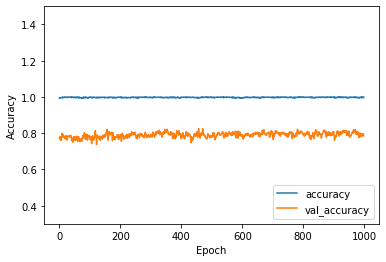

In [18]:
plt.plot(history_5.history['accuracy'], label='accuracy')
plt.plot(history_5.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1.5])
plt.legend(loc='lower right')